In [15]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from google.colab import drive
from sklearn.metrics import accuracy_score
import copy

In [16]:
# drive.mount('/content/gdrive/')

In [17]:
# Load the iris dataset
data = load_iris()
X = data['data']
T = data['target']

def one_hot_encoding(targets):
    # Get unique categories
    categories = np.unique(targets)
    # print('categories:',categories)
    # Get the number of categories
    number_of_categories = categories.size
    # Initialize an array to store the encoded target values
    encoded_T = np.array([list(np.zeros(number_of_categories, dtype=int)) for i in range(targets.size)])

    # Iterate through each target value and encode it
    for (i, t) in enumerate(targets):
        # Get the index of the category in the unique categories array
        category_index = list(categories).index(t)
        # Set the corresponding element in the encoded target array to 1
        encoded_T[i][category_index] = 1
    return encoded_T

In [18]:
def weighted_sum(x, w, b):
    """
    Compute the weighted sum of inputs.

    Parameters:
    x (numpy.ndarray): Input data.
    w (numpy.ndarray): Weights matrix.
    b (numpy.ndarray): Bias vector.

    Returns:
    numpy.ndarray or None: Weighted sum of inputs, or None if an error occurs.
    """
    try:
        # print(w.shape,x.shape)
        w = w.transpose()
        # print(w.shape,x.shape)
        z = np.dot(w, x) + b

        return z
    except Exception as e:
        # Handle exceptions, if any, and print an error message.
        print("An error occurred:", e)
        return


In [19]:
def sigmoid(z):
    """
    Compute the sigmoid function.

    Parameters:
    z (numpy.ndarray): Input array.

    Returns:
    numpy.ndarray: Output of the sigmoid function.
    """

    return 1 / (1 + np.exp(-z))

def softmax(z):
    return  np.exp(z)/ np.sum(np.exp(z))

In [20]:
def cross_entropy_loss(y,t):
   return -np.sum((t*np.log(y)))

In [21]:
def feedforward_activation(input_x, weights, biases, activation='sigmoid'):
    """
    Perform a feedforward operation with an optional activation function.

    Parameters:
    input_x (numpy.ndarray): Input data.
    weights (numpy.ndarray): Weights for the feedforward operation.
    biases (numpy.ndarray): Biases for the feedforward operation.
    activation (str): Activation function to use ('sigmoid',or 'softmax'). Default is 'sigmoid'.

    Returns:
    numpy.ndarray: Output of the feedforward operation with optional activation.
    """
    z = weighted_sum(input_x, weights, biases)

    if activation == 'sigmoid':
        nodes = sigmoid(z)
    elif activation=='softmax':
          nodes =softmax(z)
    else:
        print('Selected activation not supported, Please select sigmoid, tanh, or relu')
    return nodes,z


In [22]:
def delta_n(a_n,t_n):
     return a_n-t_n

In [23]:
def delta_m(a_m,w,s_n):

    try:
        return np.dot(w,s_n)
    except Exception as e:
        # Handle exceptions, if any, and print an error message.
        print("An error occurred:", e)
        return

In [24]:
def plot_loss(train_cost, valid_cost):
    plt.plot(range(len(train_cost)), train_cost, label='Training Loss')
    plt.plot(range(len(valid_cost)), valid_cost, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [25]:
def feedforward(input_x, weights, biases,number_of_layers_excluding_input=1, hidden_layer_activation='sigmoid',
                output_activation='sigmoid'):
    """
    Perform a feedforward operation through the neural network.

    Parameters:
    input_x (numpy.ndarray): Input data.
    weights (list of numpy.ndarray): List of weight matrices for each layer.
    biases (list of numpy.ndarray): List of bias vectors for each layer.
    hidden_layer_activation (str): Activation function for hidden layers. Default is 'sigmoid'.
    output_activation (str): Activation function for the output layer. Default is 'sigmoid'.
    number_of_layers_excluding_input (int): Number of layers excluding input in the network. Default is 1.
    """

    # List to store the outputs of each layer
    a0,z0=feedforward_activation(input_x[0], weights[0], biases[0], hidden_layer_activation)
    layer_outputs = [a0]
    weight_sums=[z0]

    # Loop through each hidden layer
    if number_of_layers_excluding_input > 1:
        for num_layer in range(1, number_of_layers_excluding_input):

            # If not the last hidden layer
            if num_layer != number_of_layers_excluding_input-1:

                # Perform feedforward with hidden layer activation
                a,z=feedforward_activation(layer_outputs[-1], weights[num_layer], biases[num_layer], hidden_layer_activation)
                layer_outputs.append(a)
                weight_sums.append(z)

            else:
                # Perform feedforward with output layer activation for the last layer

                a,z=feedforward_activation(layer_outputs[-1], weights[num_layer], biases[num_layer], output_activation)
                layer_outputs.append(a)
                weight_sums.append(z)

    return layer_outputs

In [26]:
def data_split(data, train_size=0.6, valid_size=0.20):
    np.random.shuffle(data)

    data_size = data.shape[0]
    train_end = int(train_size * data_size)
    valid_end = train_end + int(valid_size * data_size)

    train_data = data[:train_end]
    valid_data = data[train_end:valid_end]
    test_data = data[valid_end:]

    return train_data, valid_data, test_data

In [27]:
def neural_training(input_x, T,train_size=0.5,valid_size=0.25,number_of_nodes_per_hidden_layer=[], learning_rate=0.01, hidden_layer_activation='sigmoid', output_activation='sigmoid',
                    nodes_inc=2, max_epoch=3000):
    # Determine the number of input features
    number_of_features = input_x[0].size
    num_output_nodes=len(T[0])
    # Combine input features and targets into a dataset
    data = np.array(list(zip(input_x, T)), dtype=object)
    train_data,valid_data,test_data=data_split(data,train_size,valid_size)

    # plot_ann_architecture(number_of_nodes_per_hidden_layer, number_of_features, num_output_nodes)
    # If no hidden layer structure is provided, create a default structure
    if len(number_of_nodes_per_hidden_layer) == 0:
        number_of_layers_excluding_input = int(number_of_features * 2 / 3) + 1
        number_of_nodes_per_hidden_layer = [number_of_features + nodes_inc for _ in range(number_of_layers_excluding_input - 1)]
    else:
        number_of_layers_excluding_input = len(number_of_nodes_per_hidden_layer) + 1

    # Add the number of output nodes to the hidden layer structure
    number_of_nodes_per_hidden_layer.append(num_output_nodes)

    # Initialize weights and biases with random values
    w = [np.random.uniform(low=-1, high=1, size=(number_of_features, number_of_nodes_per_hidden_layer[0]))]
    b = [np.random.uniform(low=-1, high=1, size=(num)) for num in number_of_nodes_per_hidden_layer]

    for i in range(0, number_of_layers_excluding_input - 1):
        w.append(np.random.uniform(low=-1, high=1, size=(number_of_nodes_per_hidden_layer[i], number_of_nodes_per_hidden_layer[i + 1])))


    # Initialize the cost list
    train_cost = []
    valid_cost = []

    D= np.array(list(zip(train_data,valid_data)), dtype=object)
    # Initialize the epoch counter
    epoch = 1

    # Training loop
    while True:
        # Shuffle the dataset
        np.random.shuffle(D)

        # Lists to store predicted and actual targets
        pred_train_target = []
        pred_valid_target = []

        prev_w = copy.deepcopy(w)
        for ((x_train, t_train), (x_valid, t_valid)) in D:
            # Perform feedforward pass for training data
            output_train_activations= feedforward([x_train], w, b, number_of_layers_excluding_input, hidden_layer_activation=hidden_layer_activation, output_activation=output_activation)
            pred_train_target.append([output_train_activations[-1], t_train])

            # Perform feedforward pass for validation data
            output_valid_activations= feedforward([x_valid], w, b, number_of_layers_excluding_input, hidden_layer_activation=hidden_layer_activation, output_activation=output_activation)
            pred_valid_target.append([output_valid_activations[-1], t_valid])
            errors=[]
            # Calculate output layer error
            s_n = delta_n(output_train_activations[-1], t_train)
            errors.append(s_n)

            # Backpropagate the error through the network
            for (a_m, w_mn) in zip(output_train_activations[:-1][::-1], w[::-1]):
                s_n = errors[-1]
                s_m = delta_m(a_m, w_mn, s_n)
                errors.append(s_m)

            # Update weights and biases using gradient descent
            for (i, (a_m, s_n)) in enumerate(zip(output_train_activations, errors[::-1])):
                w[i] -= learning_rate * s_n * a_m
                b[i] -= learning_rate * s_n

        # Calculate and store the cost function
        train_cost.append(cross_entropy_loss(np.array(pred_train_target)[:, 0], np.array(pred_train_target)[:, 1]))
        valid_cost.append(cross_entropy_loss(np.array(pred_valid_target)[:, 0], np.array(pred_valid_target)[:, 1]))

        # Calculate accuracy
        # accuracy = 1 - cost[-1] / T.size

        # Check if weights have not changed
        # no_update = all(np.array_equal(a, b) for a, b in zip(w,prev_w))

        # Check termination conditions
        if epoch >= max_epoch :
            # print(f'epoch >= max_epoch={epoch >= max_epoch} or no_update={no_update}')

            plot_loss(train_cost,valid_cost)

            break
         # Increment epoch counter
        epoch += 1

    return test_data,w, b, number_of_layers_excluding_input, hidden_layer_activation, output_activation


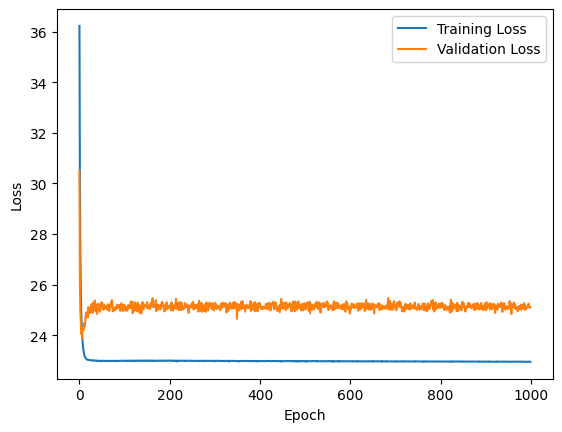

In [29]:
input_X=data['data']
targets=one_hot_encoding(T)

# a_rate,[w,b,res]=neural_training(input_X,targets,learning_rate=0.01,number_of_nodes_per_hidden_layer=[6,5,4],hidden_layer_activation='sigmoid',output_activation='sigmoid',
#                                  acceptable_accuracy=0.88,min_epoch=2)
test_data,w, b, number_of_layers_excluding_input, hidden_layer_activation, output_activation=neural_training(input_X,targets,max_epoch=1000,train_size=0.6,valid_size=0.15,learning_rate=0.01,number_of_nodes_per_hidden_layer=[6,3,5,4],hidden_layer_activation='sigmoid',output_activation='softmax')
